# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Transfer learning for computer vision



In [ ]:
"""
How to train a convolutional neural network for image classification using transfer learning.
"""

# Import python modules

In [13]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode

# Problem statement

In [ ]:
"""
You are tasked to train a model to classify ants and bees. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if 
trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.
This dataset is a very small subset of imagenet.
"""

# Load data

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualise a few images

In [ ]:
"""
Let’s visualize a few training images so as to understand the data augmentations.
"""

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

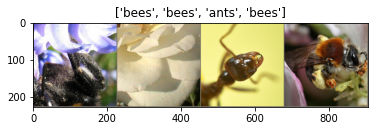

In [19]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [ ]:
"""
Now, let’s write a general function to train a model. Here, we will illustrate:

    Scheduling the learning rate
    Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.
"""

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions

In [ ]:
"""
Generic function to display predictions for a few images.
"""

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

In [ ]:
"""
Load a pretrained model and reset final fully connected layer.
"""

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
"""
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.
"""

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4883 Acc: 0.7090
val Loss: 0.2210 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4951 Acc: 0.7910
val Loss: 0.2543 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5107 Acc: 0.8197
val Loss: 0.2623 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4405 Acc: 0.8320
val Loss: 0.3890 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5394 Acc: 0.7828
val Loss: 0.4568 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4428 Acc: 0.8115
val Loss: 0.4493 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.3780 Acc: 0.8607
val Loss: 0.2610 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2886 Acc: 0.8811
val Loss: 0.2895 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2652 Acc: 0.8852
val Loss: 0.2549 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2608 Acc: 0.8893
val Loss: 0.2759 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2972 Acc: 0.8770
val Loss: 0.2627 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2745 Acc: 0.8770
val Loss: 0.3190 Acc: 0.9150

Ep

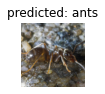

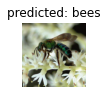

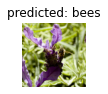

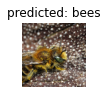

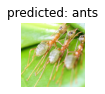

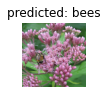

In [14]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [ ]:
"""
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze 
the parameters so that the gradients are not computed in backward().
"""

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
"""
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t 
need to be computed for most of the network. However, forward does need to be computed.
"""

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6554 Acc: 0.6270
val Loss: 0.2396 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4869 Acc: 0.7746
val Loss: 0.3067 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4560 Acc: 0.7992
val Loss: 0.5188 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.7620 Acc: 0.6885
val Loss: 0.2076 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.6078 Acc: 0.7500
val Loss: 0.2204 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4569 Acc: 0.7869
val Loss: 0.2169 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5341 Acc: 0.7705
val Loss: 0.2608 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4122 Acc: 0.8115
val Loss: 0.2364 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3144 Acc: 0.8402
val Loss: 0.2092 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3974 Acc: 0.8402
val Loss: 0.2101 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2931 Acc: 0.8607
val Loss: 0.2247 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3254 Acc: 0.8484
val Loss: 0.2238 Acc: 0.9281

Ep

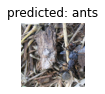

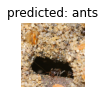

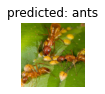

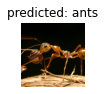

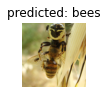

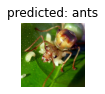

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# References
<hr style="border:2px solid black"> </hr>


- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://cs231n.github.io/transfer-learning/

